<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"> <img src="images/ecmwf.png" style="width:250px" alt="ECMWF logo"> <img src="images/googleresearch.png" style="width:250px" alt="Google logo">

# Basic Visualization using `matplotlib` and `Cartopy`

---

## Overview
A team at [Google Research & Cloud](https://research.google/) are making parts of the [ECMWF Reanalysis version 5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) (aka **ERA-5**) accessible in a [Analysis Ready, Cloud Optimized](https://www.frontiersin.org/articles/10.3389/fclim.2021.782909/full) (aka **ARCO**) format.

In this notebook, we will do the following:

1. Access the [ERA-5 ARCO](https://github.com/google-research/arco-era5) catalog
1. Select a particular dataset and variable from the catalog
1. Convert the data from Gaussian to Cartesian coordinates
1. Plot a map of sea-level pressure at a specific date and time using Matplotlib and Cartopy.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Xarray](https://foundations.projectpythia.org/core/xarray) | Necessary | |


- **Time to learn**: 30 minutes

---

## Imports

In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.spatial
import numpy as np
import cf_xarray as cfxr

## Access the ARCO ERA-5 catalog on Google Cloud

Test bucket access with `fsspec`

In [2]:
fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/co')

['gcp-public-data-arco-era5/co/model-level-moisture.zarr',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr']

Let's open the **single-level-reanalysis** Zarr file.

In [3]:
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr', 
    chunks={'time': 48},
    consolidated=True,
)

In [4]:
print(f'size: {reanalysis.nbytes / (1024 ** 4)} TB')

size: 28.02835009436967 TB


That's ... a big file! But Xarray is just *lazy loading* the data. We can access the dataset's metadata:

In [5]:
reanalysis

<xarray.Dataset>
Dimensions:              (time: 374016, values: 542080)
Coordinates:
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
    latitude             (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * time                 (time) datetime64[ns] 1979-01-01 ... 2021-08-31T23:0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    d2m                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    hcc                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl1                (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl2                (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl3                (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    ...                   ...
    tsn                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u10                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u100                 (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v10                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v100                 (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    z                    (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    GRIB_edition:              1
    GRIB_subCentre:            0
    history:                   2022-09-23T18:56 GRIB to CDM+CF via cfgrib-0.9...
    institution:               European Centre for Medium-Range Weather Forec...
    pangeo-forge:inputs_hash:  5f4378143e9f42402424280b63472752da3aa79179b53b...
    pangeo-forge:recipe_hash:  0c3415923e347ce9dac9dc5c6d209525f4d45d799bd25b...
    pangeo-forge:version:      0.9.1

Let's look at the mean sea-level pressure variable.

In [6]:
msl = reanalysis.msl
msl

<xarray.DataArray 'msl' (time: 374016, values: 542080)>
dask.array<open_dataset-fcc3dcb3919496f1bd4d11a8ead6d9b7msl, shape=(374016, 542080), dtype=float32, chunksize=(48, 542080), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
    latitude             (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * time                 (time) datetime64[ns] 1979-01-01 ... 2021-08-31T23:0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Attributes: (12/25)
    GRIB_N:                                   320
    GRIB_NV:                                  0
    GRIB_cfName:                              air_pressure_at_mean_sea_level
    GRIB_cfVarName:                           msl
    GRIB_dataType:                            an
    GRIB_gridDefinitionDescription:           Gaussian Latitude/Longitude Grid
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               Pa
    long_name:                                Mean sea level pressure
    standard_name:                            air_pressure_at_mean_sea_level
    units:                                    Pa

There are two dimensions to this variable ... **time** and **values**. The former is straightforward:

In [7]:
msl.time

<xarray.DataArray 'time' (time: 374016)>
array(['1979-01-01T00:00:00.000000000', '1979-01-01T01:00:00.000000000',
       '1979-01-01T02:00:00.000000000', ..., '2021-08-31T21:00:00.000000000',
       '2021-08-31T22:00:00.000000000', '2021-08-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
    number               int64 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * time                 (time) datetime64[ns] 1979-01-01 ... 2021-08-31T23:0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

The time resolution is hourly, commencing at 0000 UTC 1 January 1979 and running through 2300 UTC 31 August 2021.

The second dimension, **values**, represents the actual data values. In order to usefully visualize and/or analyze it, we will need to regrid it onto a standard cartesian (in this case, latitude-longitude) grid.

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger!</p>
    It might be tempting to run the code cell <code>msl.values</code> here, but doing so will force all the data to be actively read into memory! Since this is a very large dataset, we definitely don't want to do that!
</div>

## Regrid to cartesian coordinates

These reanalyses are in their native, Guassian coordinates. We will define and use several functions to convert them to a lat-lon grid, using several functions described in the [ARCO ERA-5 GCP example notebooks](https://github.com/google-research/arco-era5/tree/main/docs)

In [8]:
def mirror_point_at_360(ds):
  extra_point = (
      ds.where(ds.longitude == 0, drop=True)
      .assign_coords(longitude=lambda x: x.longitude + 360)
  )
  return xr.concat([ds, extra_point], dim='values')

def build_triangulation(x, y):
  grid = np.stack([x, y], axis=1)
  return scipy.spatial.Delaunay(grid)

def interpolate(data, tri, mesh):
  indices = tri.find_simplex(mesh)
  ndim = tri.transform.shape[-1]
  T_inv = tri.transform[indices, :ndim, :]
  r = tri.transform[indices, ndim, :]
  c = np.einsum('...ij,...j', T_inv, mesh - r)
  c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
  result = np.einsum('...i,...i', data[:, tri.simplices[indices]], c)
  return np.where(indices == -1, np.nan, result)

Select a particular time range from the dataset

In [9]:
ds93 = msl.sel(time=slice('1993-03-13T18:00:00','1993-03-13T19:00:00')).compute().pipe(mirror_point_at_360)
ds93

<xarray.DataArray 'msl' (time: 2, values: 542720)>
dask.array<concatenate, shape=(2, 542720), dtype=float32, chunksize=(2, 542080), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float64 100.0
    entireAtmosphere     float64 0.0
    latitude             (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 0
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
  * time                 (time) datetime64[ns] 1993-03-13T18:00:00 1993-03-13...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: values
Attributes: (12/25)
    GRIB_N:                                   320
    GRIB_NV:                                  0
    GRIB_cfName:                              air_pressure_at_mean_sea_level
    GRIB_cfVarName:                           msl
    GRIB_dataType:                            an
    GRIB_gridDefinitionDescription:           Gaussian Latitude/Longitude Grid
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               Pa
    long_name:                                Mean sea level pressure
    standard_name:                            air_pressure_at_mean_sea_level
    units:                                    Pa

Regrid to a lat-lon grid.

In [10]:
tri = build_triangulation(ds93.longitude, ds93.latitude)

longitude = np.linspace(0, 360, num=360*4+1)
latitude = np.linspace(-90, 90, num=180*4+1)

mesh = np.stack(np.meshgrid(longitude, latitude, indexing='ij'), axis=-1)

grid_mesh = interpolate(ds93.values, tri, mesh)

Construct an Xarray `DataArray` from the regridded array.

In [11]:
da = xr.DataArray(data=grid_mesh,
                dims=["time", "longitude", "latitude"],
                coords=[('time', ds93.time.data), ('longitude', longitude), ('latitude', latitude)],
                name='msl')

Add some metadata to the `DataArray`'s coordinate variables.

In [12]:
da.longitude.attrs['long_name'] = 'longitude'
da.longitude.attrs['short_name'] = 'lon'
da.longitude.attrs['units'] = 'degrees_east'
da.longitude.attrs['axis'] = 'X'

In [13]:
da.latitude.attrs['long_name'] = 'latitude'
da.latitude.attrs['short_name'] = 'lat'
da.latitude.attrs['units'] = 'degrees_north'
da.latitude.attrs['axis'] = 'Y'

In [14]:
da.time.attrs['long_name'] = 'time'

In [15]:
da

<xarray.DataArray 'msl' (time: 2, longitude: 1441, latitude: 721)>
array([[[            nan, 100002.69017743, 100017.98893632, ...,
         101304.89829242, 101286.78434817,             nan],
        [            nan, 100000.79174116, 100014.89271227, ...,
         101302.38406705, 101286.66494564,             nan],
        [            nan, 100002.16344993, 100011.395909  , ...,
         101299.81740898, 101287.19520441,             nan],
        ...,
        [            nan,  99999.30903704,  99999.145909  , ...,
         101296.64240898, 101285.92038913,             nan],
        [            nan,  99998.18678864, 100008.76771227, ...,
         101300.79656705, 101285.75316879,             nan],
        [            nan, 100002.69017743, 100017.98893632, ...,
         101304.89829242, 101286.78434817,             nan]],

       [[            nan,  99998.72108319, 100012.14547759, ...,
         101375.60015564, 101364.37691245,             nan],
        [            nan,  99997.98017601, 100011.52364926, ...,
         101374.04479448, 101364.84414705,             nan],
        [            nan,  99998.81250663, 100010.64536355, ...,
         101372.49886357, 101365.04251313,             nan],
        ...,
        [            nan,  99995.68085761,  99998.14536355, ...,
         101369.57386357, 101363.79856855,             nan],
        [            nan,  99994.82433162, 100005.27364926, ...,
         101372.58229448, 101363.96374431,             nan],
        [            nan,  99998.72108319, 100012.14547759, ...,
         101375.60015564, 101364.37691245,             nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1993-03-13T18:00:00 1993-03-13T19:00:00
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8 360.0
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0

Select only the first time in the `DataArray` and convert to hPa.

In [16]:
slp = da.isel(time=0)/100.

Get a quick look at the grid to ensure all looks good.

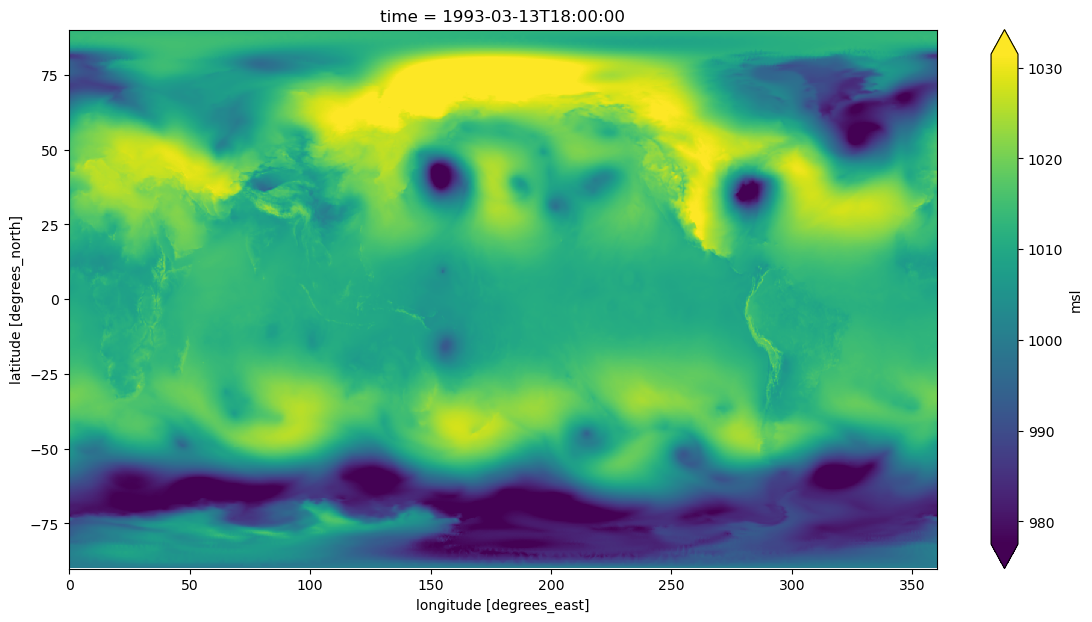

In [17]:
slp.plot(x='longitude', y='latitude', cmap='viridis', size=7, aspect=2, add_colorbar=True, robust=True)

## Plot the data on a map

In [18]:
nx,ny = np.meshgrid(longitude,latitude,indexing='ij')

In [19]:
timeStr = '1993-03-13T18:00'

tl1 = f'ERA-5 SLP (hPa)'
tl2 = f'Valid at: {timeStr}'
title_line = (tl1 + '\n' + tl2 + '\n') # concatenate the two strings and add return characters

In [20]:
cint = np.arange(900,1080,4)

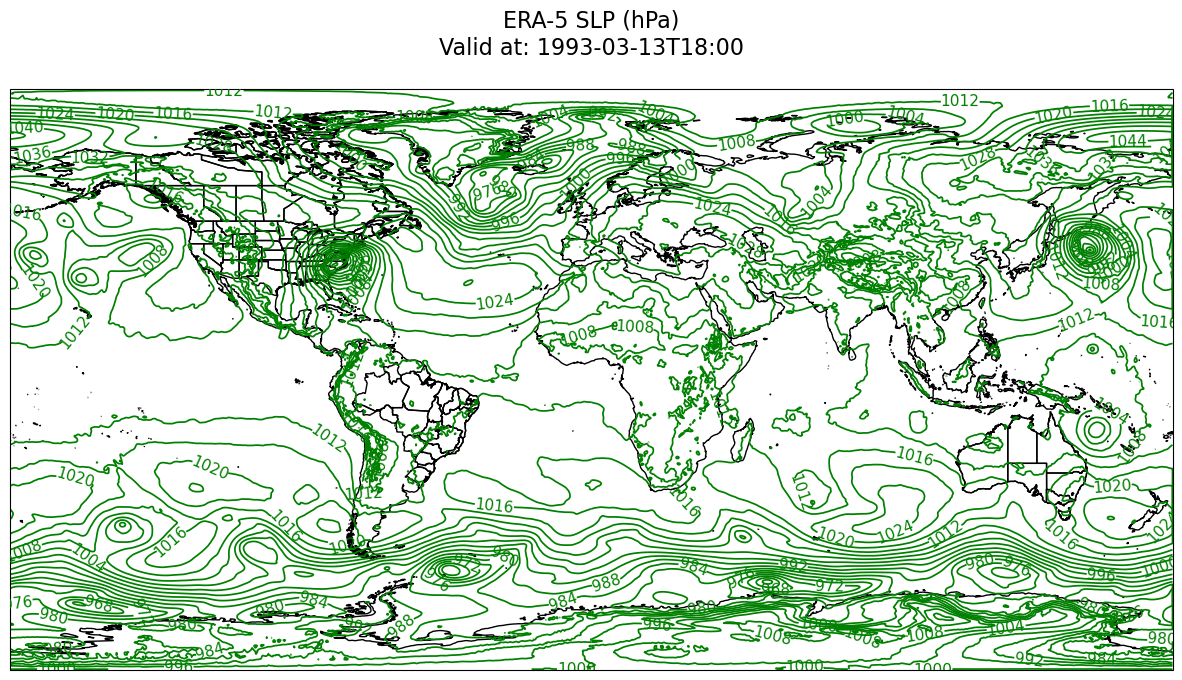

In [21]:
res = '50m'
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
#ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
#CL = slp.cf.plot.contour(levels=cint,linewidths=1.25,colors='green')
CL = ax.contour(nx, ny, slp, transform=ccrs.PlateCarree(),levels=cint, linewidths=1.25, colors='green')
ax.clabel(CL, inline_spacing=0.2, fontsize=11, fmt='%.0f')

title = plt.title(title_line,fontsize=16)


---

## Summary
In this notebook, we have accessed one of the ARCO ERA-5 datasets, regridded from the ECMWF native spectral to cartesian lat-lon coordinates, and created a map of sea-level pressure for a particular date and time.
### What's next?
In the next notebook, we will leverage the [Holoviz ecosystem](https://holoviz.org) and create interactive visualizations of the ARCO ERA-5 datasets.

## Resources and references

 - This notebook follows the general workflow as used in the [Google Research ARCO-ERA5 Surface Reanlysis Walkthrough notebook](https://github.com/google-research/arco-era5/blob/main/docs/0-Surface-Reanalysis-Walkthrough.ipynb)
 
